In [263]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.optimizers import Adam
import math
import pickle
import pandas
from sklearn.metrics import mean_squared_error

# Andiamo a costruire il modello LSTM


Epoch 1/60
2/2 [==============================] - 8s 2s/step - loss: 0.7092 - val_loss: 0.6234
Epoch 2/60
2/2 [==============================] - 0s 189ms/step - loss: 0.5663 - val_loss: 0.3178
Epoch 3/60
2/2 [==============================] - 0s 189ms/step - loss: 0.2689 - val_loss: 0.1517
Epoch 4/60
2/2 [==============================] - 0s 196ms/step - loss: 0.1304 - val_loss: 0.0719
Epoch 5/60
2/2 [==============================] - 0s 193ms/step - loss: 0.0613 - val_loss: 0.0357
Epoch 6/60
2/2 [==============================] - 0s 192ms/step - loss: 0.0324 - val_loss: 0.0259
Epoch 7/60
2/2 [==============================] - 0s 201ms/step - loss: 0.0253 - val_loss: 0.0250
Epoch 8/60
2/2 [==============================] - 0s 189ms/step - loss: 0.0256 - val_loss: 0.0270
Epoch 9/60
2/2 [==============================] - 0s 189ms/step - loss: 0.0271 - val_loss: 0.0280
Epoch 10/60
2/2 [==============================] - 0s 195ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 11/60
2/2 [====

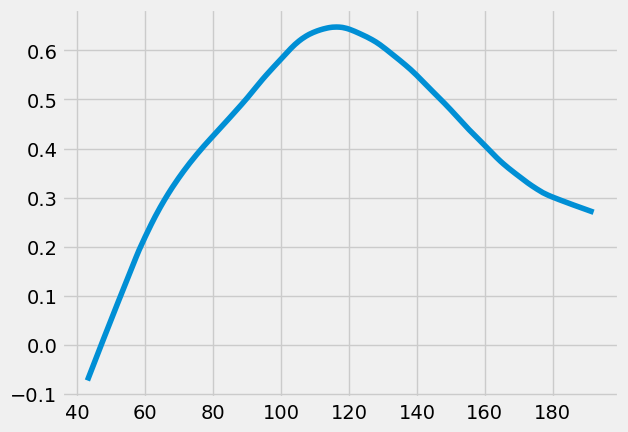

In [188]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
# generate the input and output sequences
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print()
NDVI[30].plot()

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))

datasetTrain = np.reshape(NDVI.mean().data_matrix.flatten(),(NDVI.mean().data_matrix.flatten().shape[0],1))
datasetTrain = sc.fit_transform(datasetTrain)
datasetTrain = datasetTrain.reshape(-1, 1)

datasetTest = np.reshape(NDVI[30].data_matrix.flatten(),(NDVI[30].data_matrix.flatten().shape[0],1))
datasetTest = sc.fit_transform(datasetTest)
datasetTest = datasetTest.reshape(-1, 1)

n_lookback = 30  # length of input sequences (lookback period)
n_forecast = 60  # length of output sequences (forecast period)

X = []
Y = []
for i in range(n_lookback, len(datasetTrain) - n_forecast + 1):
    X.append(datasetTrain[i - n_lookback: i])
    Y.append(datasetTrain[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

X_val = []
Y_val = []
for i in range(n_lookback, len(datasetTrain) - n_forecast + 1):
    X_val.append(datasetTest[i - n_lookback: i])
    Y_val.append(datasetTest[i: i + n_forecast])
X_val = np.array(X_val)
Y_val = np.array(Y_val)

Nepoch = 60
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=60, return_sequences=True, input_shape=(n_lookback,1)))
regressor.add(LSTM(units=120, return_sequences=True))
regressor.add(LSTM(units=240, return_sequences=True))
regressor.add(LSTM(units=120))
# The output layer
regressor.add(Dense(n_forecast))

regressor.compile(loss='mean_squared_error', optimizer='adam')
history = regressor.fit(X, Y, epochs=Nepoch,validation_data=(X_val,Y_val), batch_size=32,use_multiprocessing=True)


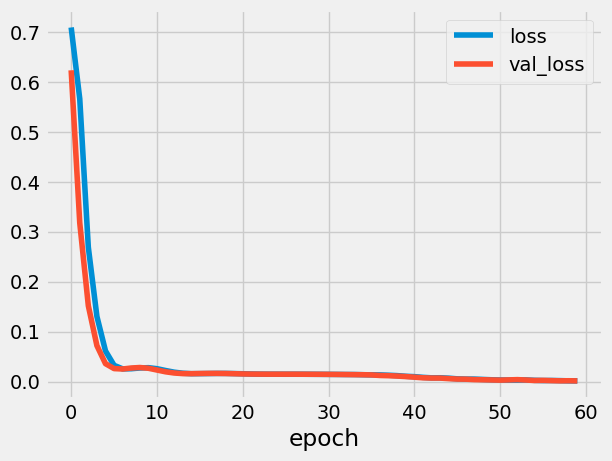

In [189]:
history_df = pd.DataFrame(columns=['epoch', 'loss'])
history_df['epoch'] = range(Nepoch)
history_df['loss'] = history.history['loss']
history_df['val_loss'] = history.history['val_loss']
history_df = history_df.set_index('epoch')
history_df.plot()

In [190]:


dataset_total = np.reshape(NDVI[90].data_matrix.flatten(),(NDVI[90].data_matrix.flatten().shape[0],1))
starttime = 10
stoptime = starttime+n_lookback
inputs = dataset_total[starttime:stoptime] # generare "l'ultima sequenza disponibile"
print(inputs[-3:])
inputs  = sc.transform(inputs)
inputs = inputs.reshape(1, n_lookback, 1)

predicted_stock_price = regressor.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price[0][:3])

[[0.43149203]
 [0.43880832]
 [0.44618876]]
1/1 [==============================] - 1s 1s/step
[0.4422391  0.45330134 0.451277  ]


C:\Users\Leo\AppData\Local\Temp\ipykernel_9256\3659863215.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


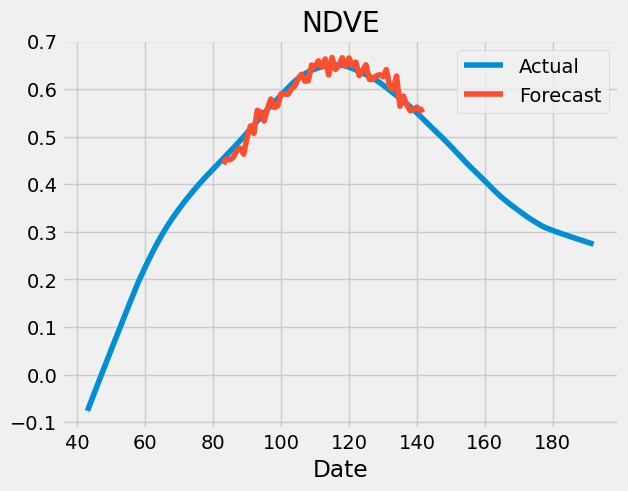

In [191]:
# organize the results in a data frame
Days = range(43,193)
df_past = pd.DataFrame(columns=['Date', 'Actual'])
df_past['Date'] = Days
df_past['Actual'] = dataset_total

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = Days[stoptime:stoptime+n_forecast]
df_future['Forecast'] = predicted_stock_price.flatten() #ha offset di 0.2 ma non si sa perche' :/ 

results = df_past.append(df_future).set_index('Date')
results.plot(title='NDVE')

# Andiamo a costruire il modello GRU

Epoch 1/60


c:\Users\Leo\.conda\envs\Agrivision\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 8s 2s/step - loss: 0.6777 - val_loss: 0.4454
Epoch 2/60
2/2 [==============================] - 0s 270ms/step - loss: 0.3663 - val_loss: 0.1684
Epoch 3/60
2/2 [==============================] - 0s 246ms/step - loss: 0.1263 - val_loss: 0.0811
Epoch 4/60
2/2 [==============================] - 0s 248ms/step - loss: 0.0731 - val_loss: 0.0609
Epoch 5/60
2/2 [==============================] - 0s 240ms/step - loss: 0.0618 - val_loss: 0.0490
Epoch 6/60
2/2 [==============================] - 0s 235ms/step - loss: 0.0464 - val_loss: 0.0434
Epoch 7/60
2/2 [==============================] - 0s 239ms/step - loss: 0.0424 - val_loss: 0.0374
Epoch 8/60
2/2 [==============================] - 0s 237ms/step - loss: 0.0362 - val_loss: 0.0313
Epoch 9/60
2/2 [==============================] - 0s 241ms/step - loss: 0.0297 - val_loss: 0.0269
Epoch 10/60
2/2 [==============================] - 0s 238ms/step - loss: 0.0266 - val_loss: 0.0259
Epoch 11/60
2/2 [================

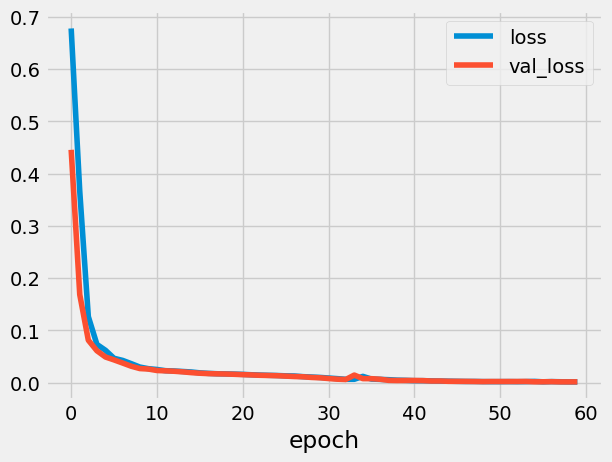

In [272]:
# The GRU architecture
Nepoch = 60
# The LSTM architecture
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=60, return_sequences=True, input_shape=(n_lookback,1),activation='tanh'))
regressorGRU.add(GRU(units=120, return_sequences=True, input_shape=(n_lookback,1),activation='tanh'))
regressorGRU.add(GRU(units=240, return_sequences=True, input_shape=(n_lookback,1),activation='tanh'))
regressorGRU.add(GRU(units=120,activation='tanh'))
regressorGRU.add(Dense(units=n_forecast))
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.compile(optimizer=Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8),loss='mean_squared_error')
# Fitting to the training set
gruHistory = regressorGRU.fit(X,Y,epochs=Nepoch,validation_data=(X_val,Y_val),batch_size=32)

history_df = pd.DataFrame(columns=['epoch', 'loss'])
history_df['epoch'] = range(Nepoch)
history_df['loss'] = gruHistory.history['loss']
history_df['val_loss'] = gruHistory.history['val_loss']
history_df = history_df.set_index('epoch')
history_df.plot()

[[0.43149203]
 [0.43880832]
 [0.44618876]]
1/1 [==============================] - 1s 1s/step
[0.4495229  0.47199973 0.47163102]


C:\Users\Leo\AppData\Local\Temp\ipykernel_9256\4081375764.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


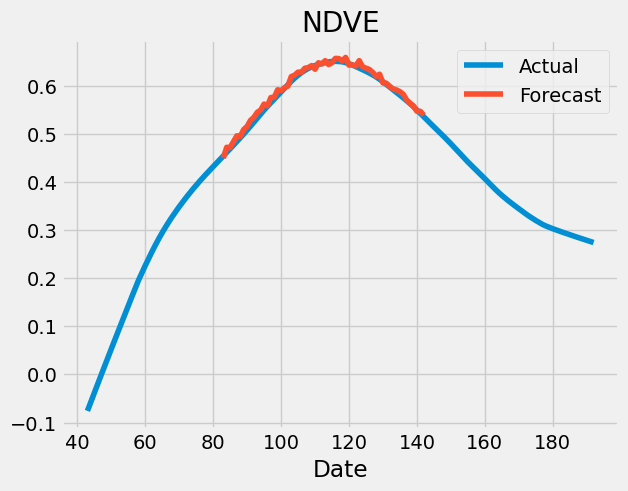

In [273]:
dataset_total = np.reshape(NDVI[90].data_matrix.flatten(),(NDVI[90].data_matrix.flatten().shape[0],1))
starttime = 10
stoptime = starttime+n_lookback
inputs = dataset_total[starttime:stoptime] # generare "l'ultima sequenza disponibile"
print(inputs[-3:])
inputs  = sc.transform(inputs)
inputs = inputs.reshape(1, n_lookback, 1)

predicted_stock_price = regressorGRU.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price[0][:3])

# organize the results in a data frame
Days = range(43,193)
df_past = pd.DataFrame(columns=['Date', 'Actual'])
df_past['Date'] = Days
df_past['Actual'] = dataset_total

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = Days[stoptime:stoptime+n_forecast]
df_future['Forecast'] = predicted_stock_price.flatten() #ha offset di 0.2 ma non si sa perche' :/ 

results = df_past.append(df_future).set_index('Date')
results.plot(title='NDVE')